# Data Acquisition

In [ ]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [ ]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"

## Mount Google Drive

In [ ]:
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


## Visual Validation of Overlapping Frames

In [ ]:
def visualize_overlapping_frames(title, framed_df, visual_set):
  for i, v in visual_set.items():
    #print( framed_df[framed_df["key"] == v]["max_amp"].idxmax() )
    findex = framed_df[framed_df["key"] == v]["max_amp"].idxmax() - 1
    hop_length = (framed_df.loc[findex]["end"] - framed_df.loc[findex]["start"]) // 2
    print(hop_length)
    frame1 = framed_df.loc[findex]["amp"]
    frame2 = framed_df.loc[findex+1]["amp"]
    frame3 = framed_df.loc[findex+2]["amp"]
    # Plot the overlapping frames
    plt.figure(figsize=(12, 6))

    # Plot first frame
    plt.plot(np.arange(len(frame1)), frame1, label='Frame 1')

    # Plot second frame
    plt.plot(np.arange(hop_length, hop_length + len(frame2)), frame2 + 1, label='Frame 2')

    # Plot third frame
    plt.plot(np.arange(2 * hop_length, 2 * hop_length + len(frame3)), frame3 + 2, label='Frame 3')

    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title(f'{title} {i} {v}')
    plt.legend()
    plt.show()

def apply_framing(audio_df):
  def create_overlapping_frames(key, amp, label, sf, frame_size, hop_length):
    # Calculate the total number of frames
    if len(amp) == len(label):
      total_frames = 1 + int((len(amp) - frame_size) / hop_length)
      dic = {"key":[], "sf":[], "start":[], "end":[], "max_amp":[], "frame_index":[], "amp":[], "label":[]}

      # Create overlapping frames
      for i in range(total_frames):
        dic["key"].append(key)
        dic["sf"].append(sf)
        dic["start"].append(i * hop_length)
        dic["end"].append(i * hop_length + frame_size)
        dic["max_amp"].append(np.max(amp[i * hop_length: i * hop_length + frame_size]))
        dic["frame_index"].append(i)
        dic["amp"].append(amp[i * hop_length: i * hop_length + frame_size])
        frames_label_raw = label[i * hop_length: i * hop_length + frame_size]

        f_label = 0
        if np.sum(frames_label_raw==1) > (len(frames_label_raw) / 2):
          f_label = 1
        dic["label"].append(f_label)

      return dic
    else:
      print('Error: non matching amp and labels', key, len(amp), len(label))

  def create_and_label_frames(audio_df):
    return create_overlapping_frames(audio_df.name, audio_df["amp"], audio_df["label"],audio_df["sf"],frame_size, hop_length)

  all_frames = {}
  for frame_size in [256, 512, 1024, 2048]:
    hop_length = frame_size // 2

    frame_df = pd.DataFrame()
    #xx = audio_df.head(1).apply(create_and_label_frames, axis=1)
    xx = audio_df.apply(create_and_label_frames, axis=1)
    for x in xx:
      if len(frame_df) > 0:
        frame_df = pd.concat([frame_df, pd.DataFrame(x)], ignore_index=True)
      else:
        frame_df = pd.DataFrame(x)

    all_frames[frame_size] = frame_df
    print(f'Frame size {frame_size}, hop_length {hop_length}, count {len(frame_df)}')
  return all_frames

### Test to Validate Reading the Saved File

In [ ]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_before_framing.feather"]

In [ ]:
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)
df_from_save

,amp,sf,shape,cough_start_end,label
key,,,,,
7ae1ffe1-2259-411f-8ead-6c107e01e824,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,[215649],"[[1.546631, 2.368818], [2.443563, 2.552804], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
de543d13-541c-4ad7-bb3c-c5c302de3aaf,"[-6.0712795e-13, -1.2264933e-12, 1.0590093e-11...",22050,[209034],"[[2.420604, 3.021429], [3.021429, 3.679121], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
494fdf0a-fc66-4292-acc4-7a69df02405f,"[-8.050144e-11, 3.2243177e-11, -5.828272e-13, ...",22050,[178605],"[[3.080564, 3.703487], [3.707493, 4.095067], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7876c549-066a-4ea1-a82e-45772114f964,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,[127008],"[[1.014883, 1.671931], [1.671931, 2.227612]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3278e364-afdd-4c39-9126-b8b4a4caf1c5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,[215649],"[[4.05953, 4.841149], [4.935187, 5.410265], [5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
37ac823b-4e39-4e85-a6c1-5e1e79979a13,"[-3.412735e-13, 3.9663672e-13, 9.605286e-13, 3...",22050,[216972],"[[1.886808, 2.188552], [2.239448, 2.514532], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
eceaa3a9-f850-4ba9-82ee-1bcd2575b99c,"[1.0154913e-12, -1.9674921e-11, 2.2162137e-11,...",22050,[104517],"[[1.82016, 2.930674]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
b05935c3-68d7-4a28-aea9-f92fbe295c6c,"[-1.4192523e-12, 1.1736758e-13, 1.7158354e-12,...",22050,[215649],"[[1.591346, 2.091523], [2.108289, 2.2494], [2....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Test to Create Frames and Labels from the Saved File Data

In [ ]:
all_frames_from_save = apply_framing(audio_df=df_from_save)

Frame size 256, hop_length 128, count 226033
Frame size 512, hop_length 256, count 112895
Frame size 1024, hop_length 512, count 56337
Frame size 2048, hop_length 1024, count 28060


In [ ]:
df_frame_from_save = all_frames_from_save[1024]
df_frame_from_save

,key,sf,start,end,max_amp,frame_index,amp,label
0,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,0,1024,1.338662e-11,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,512,1536,1.890422e-04,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,1024,2048,2.482503e-04,2,"[-5.756496e-12, -2.2846104e-12, -4.7428233e-12...",0
3,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,1536,2560,3.210614e-04,3,"[4.920621e-05, 5.74582e-05, 3.298166e-05, 7.66...",0
4,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,2048,3072,3.210614e-04,4,"[4.914635e-05, 3.0641226e-05, -2.6704272e-05, ...",0
...,...,...,...,...,...,...,...,...
56332,8254b396-cceb-4644-a723-5747cade8cf9,22050,217600,218624,0.000000e+00,425,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
56333,8254b396-cceb-4644-a723-5747cade8cf9,22050,218112,219136,0.000000e+00,426,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
56334,8254b396-cceb-4644-a723-5747cade8cf9,22050,218624,219648,0.000000e+00,427,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
56335,8254b396-cceb-4644-a723-5747cade8cf9,22050,219136,220160,0.000000e+00,428,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [ ]:
visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
visual_set

{'1st': '7ae1ffe1-2259-411f-8ead-6c107e01e824',
 'Last': '8254b396-cceb-4644-a723-5747cade8cf9'}

512


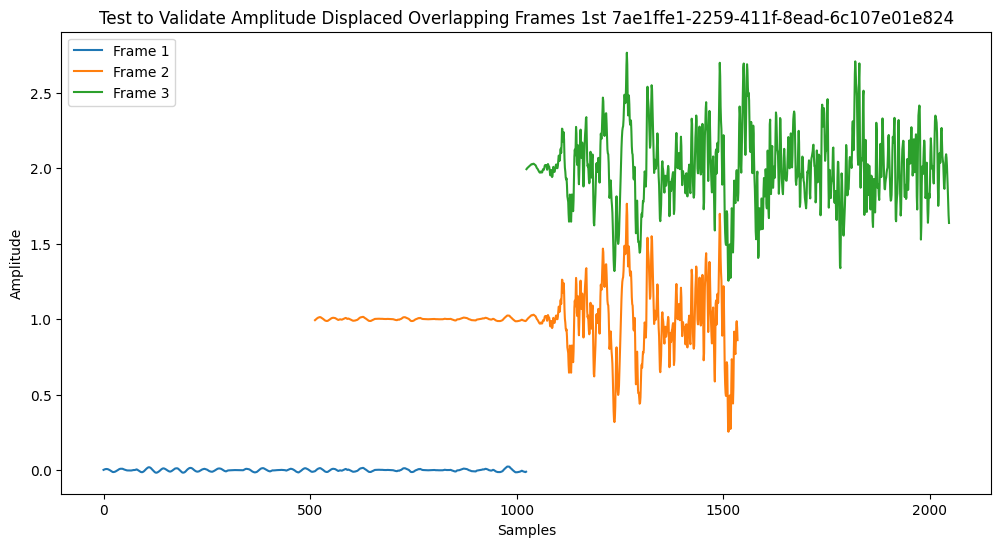

512


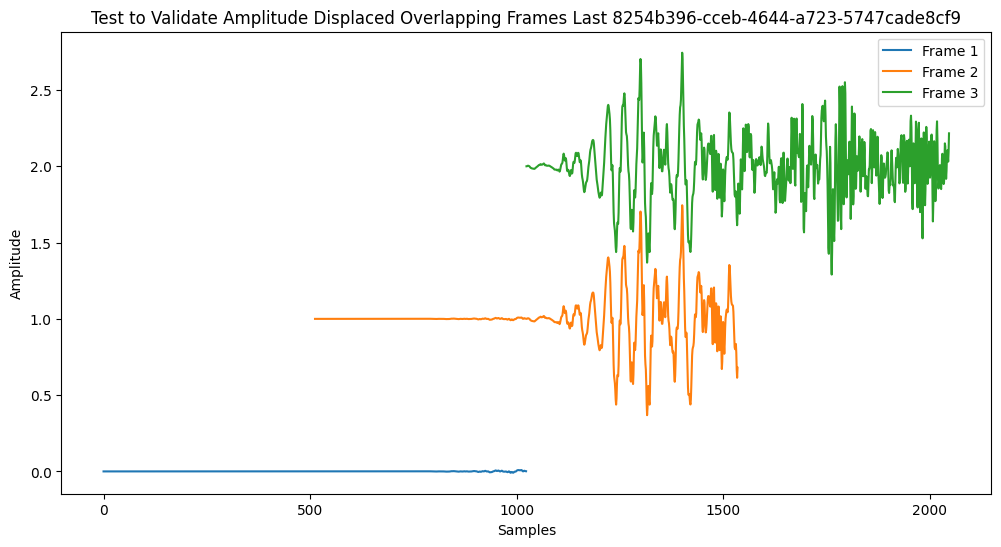

In [ ]:
visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

# Feature Extraction Code

In [ ]:
all_frames_from_save[2048]

,key,sf,start,end,max_amp,frame_index,amp,label
0,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,0,2048,0.000248,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,1024,3072,0.000321,1,"[-5.756496e-12, -2.2846104e-12, -4.7428233e-12...",0
2,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,2048,4096,0.000321,2,"[4.914635e-05, 3.0641226e-05, -2.6704272e-05, ...",0
3,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,3072,5120,0.000130,3,"[5.477116e-07, -5.5642664e-07, 5.667333e-07, -...",0
4,7ae1ffe1-2259-411f-8ead-6c107e01e824,22050,4096,6144,0.000549,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...
28055,8254b396-cceb-4644-a723-5747cade8cf9,22050,214016,216064,0.000000,209,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
28056,8254b396-cceb-4644-a723-5747cade8cf9,22050,215040,217088,0.000000,210,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
28057,8254b396-cceb-4644-a723-5747cade8cf9,22050,216064,218112,0.000000,211,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
28058,8254b396-cceb-4644-a723-5747cade8cf9,22050,217088,219136,0.000000,212,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


# Your Feature Extraction Code
